# Phase 1 - Computer Vision Project
**Done by: Mariam Yasser Abdelmageed Meckawy - 18P3059**

### Table of Contents
 1) [Gray-scale Thresholding](#Thresh)<br>
 2) [Bird-eye View](#Bird_eye)<br>
 3) [Highlighting the Lane Boundaries](#bound)<br>
 4) [Radius of Curve](#radius)<br>
 5) [Highlighting Lane](#lane)<br>
 6) [Outout](#Output)
 

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

## Gray-scale Thresholding  <a class="anchor" id="Thresh"></a>
Application on Sobel operator to get edges

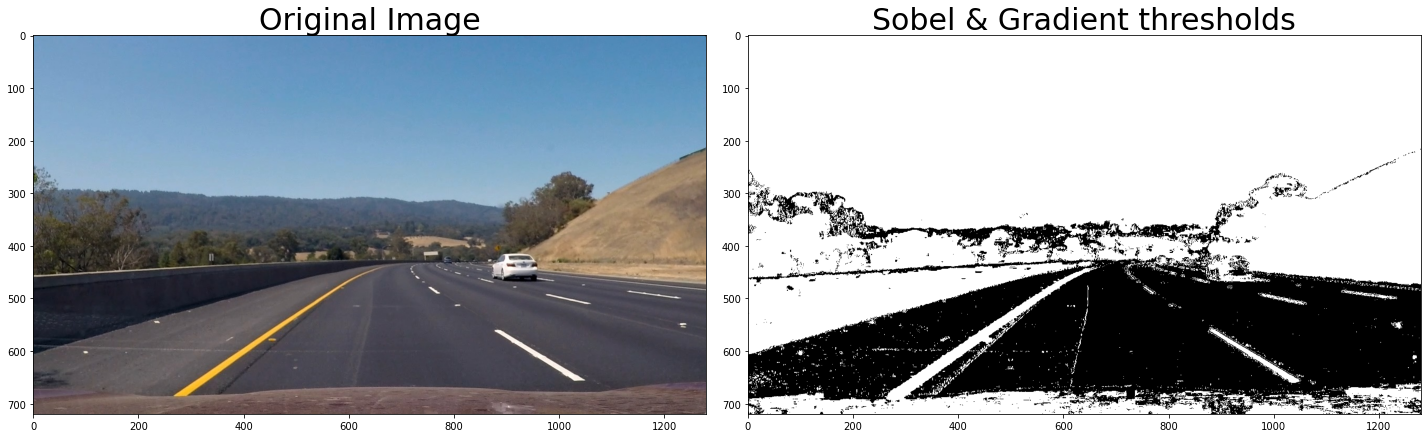

In [2]:
image = mpimg.imread('threshold.jpg')

# create color and gradient pipeline.
def color_grid_thresh(img, s_thresh=(130, 255),h_thresh=(15,100),sx_thresh=(20, 100)):

    # gray scale the image for gradient processing
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply sobel on the x-axis to get vertical edges
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx) 
    
    #converting Gray imaged to RGB colored image again
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) 
    
    # Threshold x gradient
    sx = np.zeros_like(scaled_sobel)
    sx[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Convert to HLS color space to control hue, saturation
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    # Combine the two thresholds
    combined_binary = np.zeros_like(sx)
    combined_binary[(s_binary == 1) |(h_binary == 1) | (sx == 1)] = 1
    return combined_binary
    
img_threaded = color_grid_thresh(image, s_thresh=(30, 255), h_thresh=(15,55), sx_thresh=(10, 50))
cv2.imwrite('output_images/after_thersholding.png',img_threaded)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()

ax1.set_title('Original Image', fontsize=30)
ax1.imshow(image)


ax2.set_title('Sobel & Gradient thresholds', fontsize=30)
ax2.imshow(img_threaded,cmap='gray')

## Bird's Eye View  <a class="anchor" id="Bird_eye"></a>
Application on Geometric tranformations, we will get the values of the points of the pixels we want by opening the image in paint and standing on the points we want to get their x and y values and the values will be showing in the bar at the bottom

In [3]:
img = mpimg.imread('highway1.jpg')
img_size = (img.shape[1],img.shape[0])

#points we want to change their view
src = np.float32([[705, 461],[999, 650],[303,650],[581, 462]])

print(img_size)

(1280, 720)


Text(0.5, 1.0, 'Transformed Image')

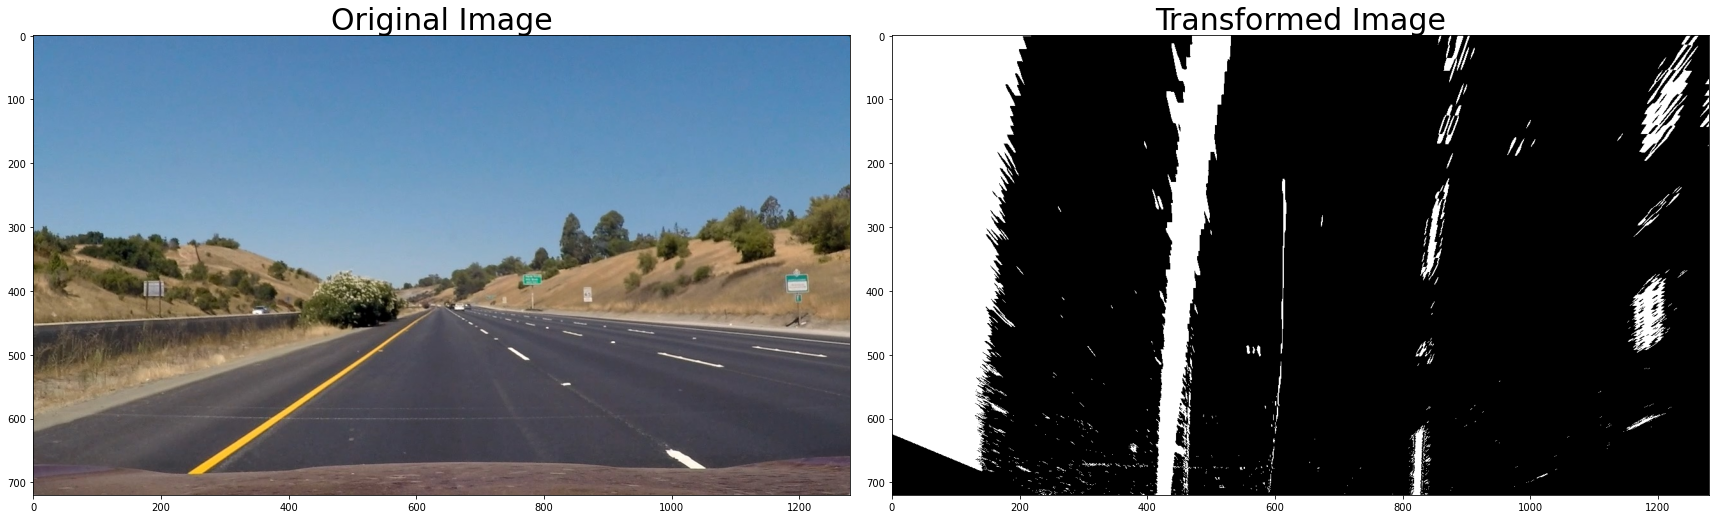

In [4]:
#output image points
dst = np.float32([[805,1],[805, 720],[410,720],[410,1]])

#Change the perspective of the road using wrapping
M = cv2.getPerspectiveTransform(src,dst)
presp = cv2.getPerspectiveTransform(dst,src)
warped = cv2.warpPerspective(img_threaded,M,img_size,flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped,cmap='gray')
ax2.set_title('Transformed Image', fontsize=30)

Now, we create a wrap function after we made sure it is working fine

In [5]:
def warped_image(img, img_threaded):
    src = np.float32([[722, 470],[1110, 720],[220,720],[570, 470]])
    dst = np.float32([[920,1],[920, 720],[320,720],[320,1]])
    M = cv2.getPerspectiveTransform(src,dst)
    persp = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img_threaded,M,img_size,flags=cv2.INTER_LINEAR)
    return warped,persp

## Highlighting the Lanes Boundaries <a class="anchor" id="bound"></a>

In [6]:
binary_warped = warped

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 15
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

C:\Users\lenovo\AppData\Local\Temp/ipykernel_3552/2039979353.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  midpoint = np.int(histogram.shape[0]//2)
C:\Users\lenovo\AppData\Local\Temp/ipykernel_3552/2039979353.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the relea

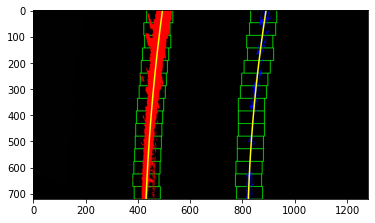

In [7]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit


out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(binary_warped)

plt.imshow(out_img)

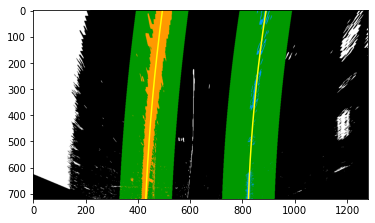

In [8]:
binary_warped = warped

# Polynomial fit values from the previous frame: left_fit, right_fit
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    # np.polyfit order is y first, then x
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    # within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.6, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return result,left_fitx,right_fitx,ploty,left_fit,right_fit

result,left_fitx,right_fitx,ploty,left_fit,right_fit = search_around_poly(binary_warped)
plt.imshow(result)

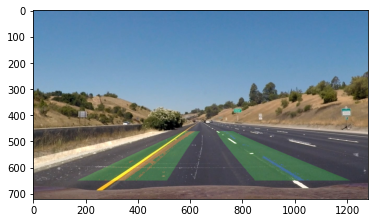

In [9]:
# Warp the detected lane boundaries back onto the original image
stacked_img = np.dstack((warped, warped, warped))*255
num_rows = warped.shape[0]
img_size = (stacked_img.shape[1],stacked_img.shape[0])

y_points = np.linspace(0, num_rows-1, num_rows)

left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))

line_points = np.vstack((left_line_window, right_line_window))
cv2.fillPoly(stacked_img, np.int_([line_points]), [255,0,0])

unwarped = cv2.warpPerspective(result, presp, img_size , flags=cv2.INTER_LINEAR)
#Highlight lane boundaries on the original image
result = cv2.addWeighted(img, 1, unwarped, 0.3, 0) 

plt.imshow(result)

## Distance from center <a class="anchor" id="center"></a>

In [10]:
binary_warped = warped
h = binary_warped.shape[0]

def find_lane_center(binary_img, l_fit, r_fit):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    if r_fit is not None and l_fit is not None:
        car_position = binary_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return center_dist


center_dist = find_lane_center(binary_warped, left_fit, right_fit)
print("the distance to the lane center is: %.2f" %center_dist, "m")

the distance to the lane center is: 0.07 m


## Radius of Curve <a class="anchor" id="radius"></a>

In [11]:
def measure_curvature_real(left_fitx, right_fitx,ploty):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #maximum y value
    y_eval = np.max(ploty)
    
    # Fit a second order polynomial to pixels in each lane
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

## Highlight Lane <a class="anchor" id="lane"></a>

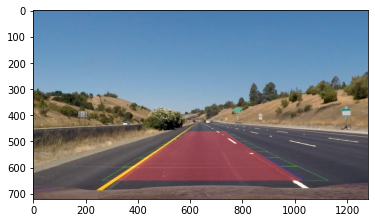

In [12]:
stacked_img2 = np.dstack((warped, warped, warped))*255
num_rows = warped.shape[0]
img_size = (stacked_img2.shape[1],stacked_img2.shape[0])

y_points = np.linspace(0, num_rows-1, num_rows)
left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))
    
line_points = np.vstack((left_line_window, right_line_window))

# Fill the area between lane boundaries
cv2.fillPoly(out_img, np.int_([line_points]), [255,0,0])
    
unwarped = cv2.warpPerspective(out_img, presp, img_size , flags=cv2.INTER_LINEAR)
result2 = cv2.addWeighted(img, 1, unwarped, 0.3, 0) #img is the original image to draw on

plt.imshow(result2)

Function

In [13]:
def draw_detected_lane(warped,out_img,img,left_fitx, right_fitx, Minv):
    stacked_img = np.dstack((warped, warped, warped))*255
    num_rows = warped.shape[0]
    img_size = (stacked_img.shape[1],stacked_img.shape[0])

    y_points = np.linspace(0, num_rows-1, num_rows)
    left_line_window = np.array(np.transpose(np.vstack([left_fitx, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_fitx, y_points]))))
    line_points = np.vstack((left_line_window, right_line_window))

    cv2.fillPoly(out_img, np.int_([line_points]), [255,0, 0])
    unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0) #img is the original image to draw on
    return result

## Output  <a class="anchor" id="Output"></a>

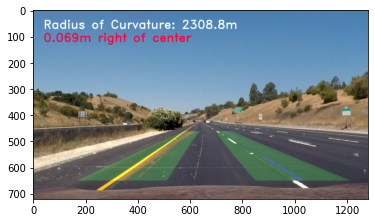

In [14]:
image = result

def draw_data_on_lane(result_img, left_curverad, right_curverad, center_dist):
    new_img = np.copy(result_img)
    h = new_img.shape[0]
    curv_radius = (left_curverad+ right_curverad)/2
    
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of Curvature: ' + '{:04.1f}'.format(curv_radius) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (255,0,60), 2, cv2.LINE_AA)
    return new_img

left_curverad, right_curverad = measure_curvature_real(left_fitx, right_fitx,ploty)
data_on_original_image = draw_data_on_lane(image, left_curverad, right_curverad, center_dist)
plt.imshow(data_on_original_image)

In [15]:
def brute_search_lane_lines(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# func to fit polynominal to a warped image to find the lane boundary
def fit_polynomial_brute_search(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = brute_search_lane_lines(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return out_img,left_fitx,right_fitx,left_fit,right_fit,ploty #out_img: lane line fitted binary image

In [16]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    # np.polyfit order is y first, then x
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

# func of searching a small margin instead of the whole width of the image for the next frame
def search_around_poly(warped_2,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = warped_2.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values
    # within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(warped_2.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warped_2, warped_2, warped_2))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.6, 0)
    
    return result,left_fitx,right_fitx,left_fit,right_fit,ploty

In [17]:
def advanced_lane_finding(img):
    global left_fit
    global right_fit
    # get color and gradient thresholded binary image that picked up lane lines
    combined_binary = color_grid_thresh(img,s_thresh=(130, 255), h_thresh=(15,100),sx_thresh=(20, 100))
    # perform a perspective transform to get the birdview of lane lines
    warped,Minv = warped_image(img, combined_binary)
    # if the polynomial coefficients of the previous frame is None then sliding windows to search fitted lane line
    # else if there are previous lane lines polynominal coefficients, then search a small margin for the current frame
    if (left_fit is None) or (right_fit is None):
        lane_detected_img,left_fitx,right_fitx,left_fit,right_fit,ploty = fit_polynomial_brute_search(warped)
    else:
        # Make sure to grab the actual values from the previous step in your project!
        left_fit = np.array(left_fit)
        right_fit = np.array(right_fit)
        lane_detected_img,left_fitx,right_fitx,left_fit,right_fit,ploty = search_around_poly(warped,left_fit,right_fit) 

    # compute the radius of curvature
    left_curverad,right_curverad = measure_curvature_real(left_fitx,right_fitx,ploty)
    # compute the offset of lane center
    center_dist = find_lane_center(warped,left_fit,right_fit)
    # output lane detected poly drawing on the original image
    result_img = draw_detected_lane(warped,lane_detected_img,img,left_fitx,right_fitx,Minv)
    # output the lane detection, curvature and offset of lane center image
    data_img = draw_data_on_lane(result_img,left_curverad,right_curverad,center_dist)
    data_img = np.array(data_img)
    return data_img

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# global variables to store good found left and right lane lines
left_fit = None
right_fit = None

video_output_name_2 = 'project_video_output.mp4'
input_vid = VideoFileClip('project_video.mp4')
output = input_vid.fl_image(advanced_lane_finding)
%time output.write_videofile(video_output_name_2, audio=False)

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 1min 42s
